In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN


from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

from torch_geometric.data import DataLoader

In [2]:
torch.cuda.device_count()

4

In [3]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [4]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [5]:
showers_train = torch.load('./EM_data/showers_train.pt')

In [6]:
len(showers_train)

230

In [7]:
showers_train = [shower.to(device) for shower in showers_train[:20]]

In [8]:
len(showers_train)

20

In [9]:
np.unique(showers_train[0].y.cpu().detach().numpy())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [10]:
showers_train[1].x.shape[1]

5

## Features creation

In [11]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/data[:, 0]).view(shape_0, 1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /data[:, 2]).view(shape_0,1)
    
    feat_2 = (data[:, 0]/data[:, 2]).view(shape_0,1)
    
    feat_3 = (data[:, 1]/data[:, 2]).view(shape_0,1)
    
    feat_4 = (torch.sin(feat_0) + torch.cos(feat_0))/feat_0
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3, feat_4), 1)

In [12]:
showers_train[1].x.shape[1]

10

In [13]:
showers_train[0].x[0]

tensor([-1.0178, -0.8698, -2.4331, -0.1505,  0.1620,  0.7071, -0.5502,  0.4183,
         0.3575,  1.9938], device='cuda:0')

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [14]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [15]:
Z_centered = Z - 73701. / 2

In [16]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [17]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

In [18]:
Z_0

array([-24330.68990707, -23056.30922318, -21785.49051285, ...,
        34226.60112381,  34224.50065613,  34225.58069229])

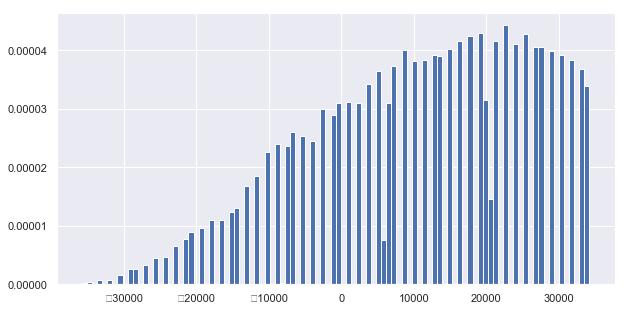

In [19]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


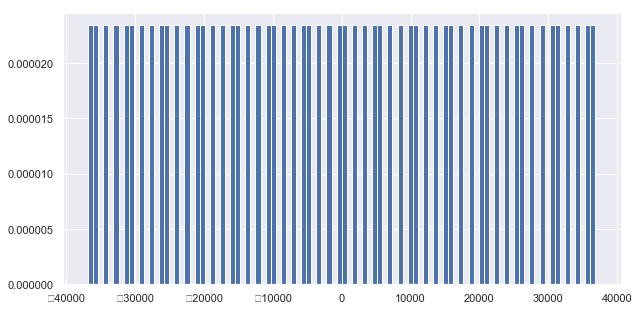

In [20]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_centered, 100, density=True)

plt.grid(True)
plt.show()

## Masks for activating only those edges that are connecting the same shower

In [21]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu()) * np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            if z_0_i == z_i:
                # TODO data.edge_index[0] vs data.edge_index[1]
                orders[i][(data.edge_index[0] == j).cpu().numpy().astype(bool)] = 1
            
    return orders.astype(np.uint8)

In [22]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

## GNN 

In [23]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels).to(device)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate(torch.index_select(edge_index[:, torch.ByteTensor(order).to(device)], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
            
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [24]:
n = showers_train[0].x.shape[1]

class GraphNN_KNN(torch.nn.Module):
    n = showers_train[0].x.shape[1]
    
    def __init__(self, k=n, dim_out=10):
        super().__init__()
        self.k = k
        
        self.emconv = EmulsionConv(self.k, self.k)    
      
        self.layer_2 = nn.Linear(self.k, 18)
        self.nonlinear_2 = nn.LeakyReLU()
        
        self.layer_3 = nn.Linear(18, 24)
        self.nonlinear_3 = nn.ReLU()

        
        self.output = nn.Linear(24, dim_out)
        
        
    def forward(self, data):
        x, edge_index, orders = data.x, data.edge_index, data.mask
        
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)  
        
        x = self.nonlinear_2(self.layer_2(x))
        
        x = self.nonlinear_3(self.layer_3(x))
        
        
        return self.output(x)


In [25]:
model = GraphNN_KNN(dim_out=288).to(device)

In [26]:
for i in range(len(showers_train)):
    showers_train[i].mask = torch.tensor(masks[i], dtype=torch.uint8)

In [27]:
train, test = train_test_split(showers_train)

In [28]:
test[0]

Data(edge_attr=[67700, 1], edge_index=[2, 67700], mask=[58, 67700], pos=[13543, 5], x=[13543, 10], y=[13543])

In [29]:
train_loader = DataLoader(train, batch_size=1, shuffle=False)

#valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    #sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test, batch_size=1, shuffle=False)

----------------

In [30]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(288*2, 144),
                                nn.Tanh(),
                                nn.Linear(144, 144),
                                nn.Tanh(),
                                nn.Linear(144, 32),
                                nn.Tanh(),
                                nn.Linear(32, 1),
                                nn.Sigmoid()).to(device)

In [31]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(model.parameters()) + list(edge_classifier.parameters()), lr=learning_rate)

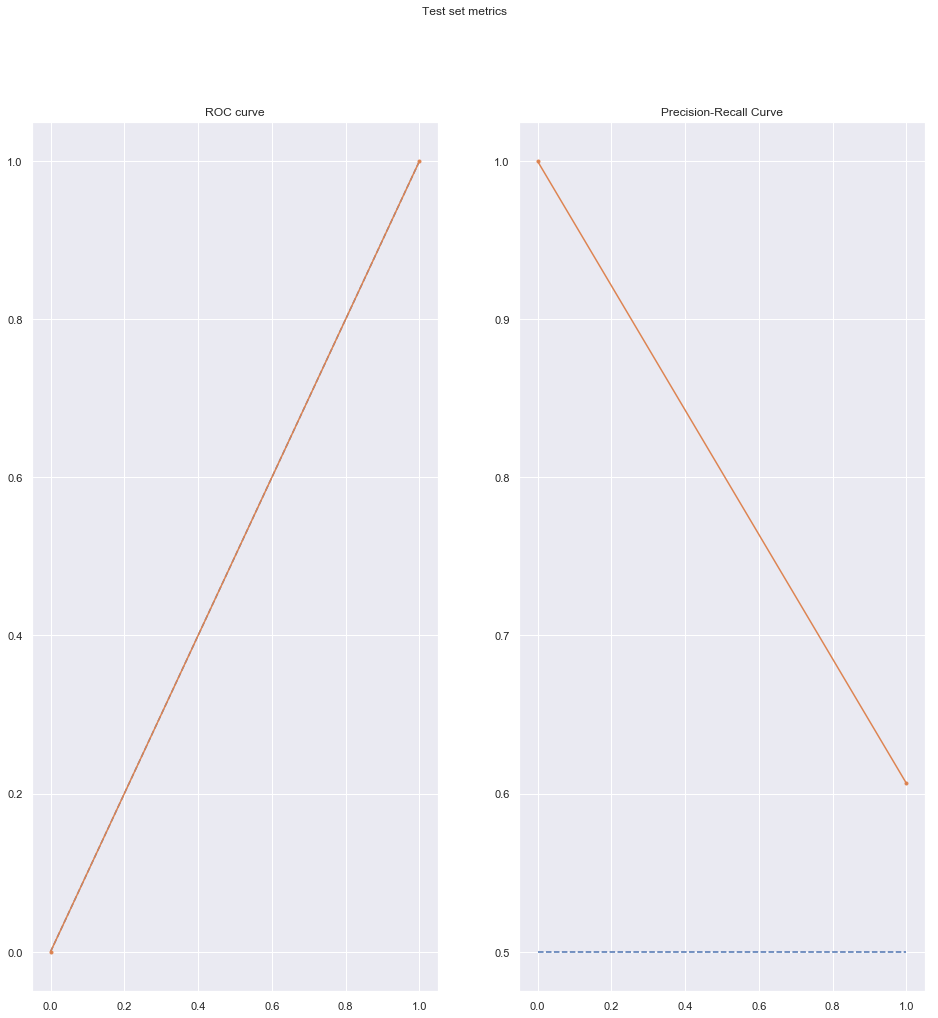

#26, Test loss: nan
mean AUC per batch: 0.500


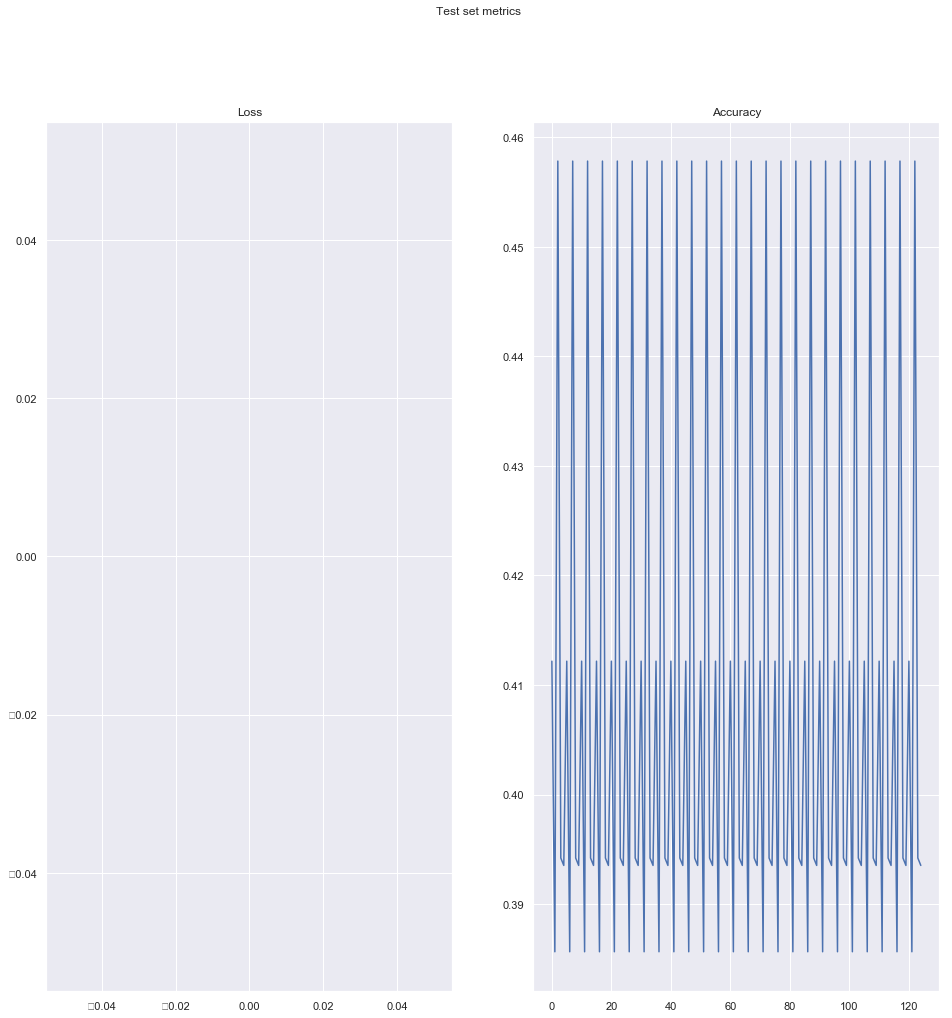

KeyboardInterrupt: 

In [35]:
n_epoch = 400

train_losses = []

test_losses = []

accs = []

aucs = []
    
for i in range(1, n_epoch + 1):
      
    for shower in train_loader:

        embeddings = model(shower)


        edge_labels = (shower.y[shower.edge_index[0]] 
                       == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                               embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data).view(-1)
        edge_predicted_clean = edge_predicted[edge_predicted == edge_predicted]
        edge_labels_clean = edge_labels[edge_predicted == edge_predicted]

        
        # calculate the batch loss
        loss = criterion(edge_predicted_clean, edge_labels_clean.float())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.detach().cpu().numpy())


    

    for shower in test_loader:
        
        embeddings = model(shower)


        edge_labels = (shower.y[shower.edge_index[0]] 
                           == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                                   embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data).view(-1)
        # edge_predicted[edge_predicted != edge_predicted] = 0.
        edge_predicted_clean = edge_predicted[edge_predicted == edge_predicted]
        edge_labels_clean = edge_labels[edge_predicted == edge_predicted]


        # calculate the batch loss
        loss = criterion(edge_predicted_clean, edge_labels_clean.float())
        loss.backward()
        test_losses.append(loss.detach().cpu().numpy())

        
        edge_predicted[edge_predicted != edge_predicted] = 0
        
        
        y_true = edge_labels.view(-1).float().cpu().detach().numpy()
        y_pred = edge_predicted.view(-1).cpu().detach().numpy()

        

        accs.append((edge_labels == (edge_predicted > 0.5)).float().mean())

        auc = roc_auc_score(y_true, y_pred)
        
        aucs.append(auc)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

        clear_output()
        
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,16))

        ax = axs[0]
        ax.plot([0, 1], [0, 1], linestyle='--')
        # plot the roc curve for the model
        ax.plot(fpr, tpr, marker='.')
        ax.set_title('ROC curve')

        ax = axs[1]
        ax.plot([0, 1], [0.5, 0.5], linestyle='--')
        ax.plot(recall, precision, marker='.')
        ax.set_title('Precision-Recall Curve')


        fig.suptitle('Test set metrics')

        plt.show()

    
    
    
    print("#%i, Test loss: %.7f"%(i+1,np.mean(test_losses)),flush=True)
    print('mean AUC per batch: %.3f' % np.mean(aucs))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,16))
    
    ax = axs[0]
    ax.plot(test_losses)
    ax.set_title('Loss')

    ax = axs[1]
    ax.plot(accs)
    ax.set_title('Accuracy')
    
    #ax = axs[1][0]
    #ax.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    #ax.plot(fpr, tpr, marker='.')
    #ax.set_title('ROC curve')

    #ax = axs[1][1]
    #ax.plot([0, 1], [0.5, 0.5], linestyle='--')
    #ax.plot(recall, precision, marker='.')
    #ax.set_title('Precision-Recall Curve')


    fig.suptitle('Test set metrics')

    plt.show()



